## ML Model for Sentiment Analysis of tweets (Elon Mush) - Part 2

 - prepared by Nixon Chan

<b>*The following code are built on DataBrick and now converted to .ipynb format for displaying on GitHub. Therefore, those code will not work under Jupyter notebook.
    
<p>Due to restriction on Databrick, the original .dbc file cannot be converted into 1 .ipynb file. So, it was separated into 3 parts. </b>

### Feature Engineer and Model Pipeline

#### LogisticRegression

In [ ]:
# Process the tweets with Tokenizer, StopWordsRemover, Custom Stop Word Remover, WordNetLemmatizer, PorterStemmer, CountVectorizer, IDF, NGRAM to create feature and use ChiSqSelector for frequre selection. Finally, feed in the feature to LogisticRegression classifier for prediction.

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF, NGram, VectorAssembler, ChiSqSelector, StringIndexer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer, PorterStemmer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import nltk

# Use 90% cases for training, 10% cases for testing
train, test = tweets_clean.randomSplit([0.9, 0.1], seed=20200819)

# Tokenizer
tokenizer = Tokenizer(inputCol="tweet", outputCol="tokens")

# StopWordsRemover
stopword_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")

# Pipeline
pipeline = Pipeline(stages=[tokenizer, stopword_remover])

# Fit the pipeline
pipeline_model = pipeline.fit(train)
tweets_filtered_train = pipeline_model.transform(train)
tweets_filtered_test = pipeline_model.transform(test)

# Additional words to remove if any
custom_stopwords = ["elon", "musk", "twitter", "rt"]



# Remove additional custom words
for custom_stopword in custom_stopwords:
    tweets_filtered_train = tweets_filtered_train.withColumn(
        'filtered', 
        F.expr(f"transform(filtered, element -> regexp_replace(element, '(?i){custom_stopword}', ''))")
    )
    tweets_filtered_test = tweets_filtered_test.withColumn(
        'filtered', 
        F.expr(f"transform(filtered, element -> regexp_replace(element, '(?i){custom_stopword}', ''))")
    )

# Filter out empty strings
tweets_filtered_train = tweets_filtered_train.withColumn('filtered', F.expr("filter(filtered, element -> element != '')"))
tweets_filtered_test = tweets_filtered_test.withColumn('filtered', F.expr("filter(filtered, element -> element != '')"))


# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Define a UDF for lemmatization
@udf(ArrayType(StringType()))
def lemmatize_udf(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply lemmatization
tweets_lemmatized_train = tweets_filtered_train.withColumn("lemmatized", lemmatize_udf("filtered"))
tweets_lemmatized_test = tweets_filtered_test.withColumn("lemmatized", lemmatize_udf("filtered"))


# Stemming
stemmer = PorterStemmer()

# Define a UDF for stemming
@udf(ArrayType(StringType()))
def stem_udf(tokens):
    return [stemmer.stem(token) for token in tokens]

# Apply stemming
tweets_stemmed_train = tweets_lemmatized_train.withColumn("stemmed", stem_udf("lemmatized"))
tweets_stemmed_test = tweets_lemmatized_test.withColumn("stemmed", stem_udf("lemmatized"))


cv = CountVectorizer(vocabSize=2**16, inputCol="stemmed", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="1gram_idf", minDocFreq=5) #minDocFreq: remove sparse terms
ngram = NGram(n=2, inputCol="filtered", outputCol="2gram")
ngram_hashingtf = HashingTF(inputCol="2gram", outputCol="2gram_tf", numFeatures=20000)
ngram_idf = IDF(inputCol='2gram_tf', outputCol="2gram_idf", minDocFreq=5) 

# Assemble all text features
assembler = VectorAssembler(inputCols=["1gram_idf", "2gram_tf"], outputCol="rawFeatures")

# Chi-square variable selection
selector = ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")

#string_indexer
string_indexer = StringIndexer(inputCol="label", outputCol="indexed_label")

# Regression model estimator
lr = LogisticRegression(maxIter=100, labelCol="indexed_label", family="multinomial")

# Build the pipeline
pipeline = Pipeline(stages=[cv, idf, ngram, ngram_hashingtf, ngram_idf, assembler, selector, string_indexer, lr])

# Pipeline model fitting
pipeline_model = pipeline.fit(tweets_stemmed_train)
pipeline_model.transform(tweets_stemmed_train)
predictions = pipeline_model.transform(tweets_stemmed_test)

# Display the result
display(predictions)

Accuracy Score: 0.7536
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80      4040
         1.0       0.74      0.76      0.75      3093
         2.0       0.63      0.68      0.65      1665

    accuracy                           0.75      8798
   macro avg       0.73      0.74      0.73      8798
weighted avg       0.76      0.75      0.75      8798



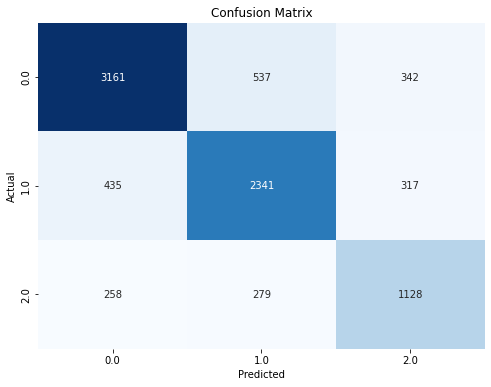

In [0]:
# Based on the predication from LogisticRegression, evaluate the performance of the model using accuracy, classification report and confusion matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# MulticlassClassificationEvaluator for multiclass classification metrics
evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="indexed_label")

# Calculate Accuracy
accuracy = evaluator.evaluate(predictions)

# Print the evaluation metric (accuracy)
print("Accuracy Score: {0:.4f}".format(accuracy))

# Convert to Pandas DataFrame
lr_predictions_pd = predictions.select("indexed_label", "prediction").toPandas()

# Print out classification report
from sklearn.metrics import classification_report
print(classification_report(lr_predictions_pd['indexed_label'], lr_predictions_pd['prediction']))

# Plot the confusion matrix as a heatmap
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(lr_predictions_pd['indexed_label'], lr_predictions_pd['prediction'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(lr_predictions_pd['prediction']), yticklabels=np.unique(lr_predictions_pd['prediction']))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



Accuracy Score (Overall Accuracy):

75.36%: The percentage of correctly predicted instances out of the total instances.
Precision, Recall, and F1-score for Each Sentiment Class:

Class 0 (Neutral):

- Precision (82%): The percentage of correctly predicted neutral tweets out of all predicted neutral tweets. Precision measures accuracy among the predicted positive instances.
- Recall (78%): The percentage of correctly predicted neutral tweets out of all actual neutral tweets. Recall measures how well the model captures instances of the positive class.
- F1-score (80%): The harmonic mean of precision and recall. It provides a balance between precision and recall.

Class 1 (Positive):
- Precision (74%): The percentage of correctly predicted positive tweets out of all predicted positive tweets.
- Recall (76%): The percentage of correctly predicted positive tweets out of all actual positive tweets.
- F1-score (75%): The harmonic mean of precision and recall for the positive class.

Class 2 (Negative):
- Precision (63%): The percentage of correctly predicted negative tweets out of all predicted negative tweets.
- Recall (68%): The percentage of correctly predicted negative tweets out of all actual negative tweets.
- F1-score (65%): The harmonic mean of precision and recall for the negative class.